In [ ]:
pip install xgboost lightgbm catboost scikit-learn pandas matplotlib shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

# Load dataset
df = pd.read_csv("student-mat.csv", delimiter=";")
print(df)
# Drop features
df = df.drop(columns=["school", "G1", "G2"])

# Create Binary and 5-Level targets
df["G3_binary"] = df["G3"].apply(lambda x: 1 if x >= 10 else 0)

def convert_grade(g3):
    if g3 >= 16:
        return 'A'
    elif g3 >= 14:
        return 'B'
    elif g3 >= 12:
        return 'C'
    elif g3 >= 10:
        return 'D'
    else:
        return 'F'

df["G3_5class"] = df["G3"].apply(convert_grade)
df = df.drop(columns=["G3"])

# Encode categorical variables
categorical_cols = df.select_dtypes(include="object").columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features and targets
X = df.drop(columns=["G3_binary", "G3_5class"])
y_binary = df["G3_binary"]
y_5class = df["G3_5class"]

# Scale data (needed for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models and hyperparameters
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [3, 5, 10, None]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [100, 200], 'max_depth': [3, 5]}),
    "LightGBM": (LGBMClassifier(), {'n_estimators': [100, 200], 'num_leaves': [31, 50]}),
    "CatBoost": (CatBoostClassifier(verbose=0), {'iterations': [100, 200], 'depth': [3, 5]}),
    "SVM": (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation function
def evaluate_model(name, model, param_grid, X, y):
    print(f"Training {name}...")
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    if name == "SVM":
        grid.fit(X_scaled, y)
        y_pred = grid.predict(X_scaled)
        y_proba = grid.predict_proba(X_scaled)[:, 1] if len(set(y)) == 2 else None
    else:
        grid.fit(X, y)
        y_pred = grid.predict(X)
        y_proba = grid.predict_proba(X)[:, 1] if len(set(y)) == 2 else None

    result = {
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, average='macro'),
        "Recall": recall_score(y, y_pred, average='macro'),
        "F1 Score": f1_score(y, y_pred, average='macro')
    }
    if y_proba is not None:
        result["ROC AUC"] = roc_auc_score(y, y_proba)
    return result

# Run for binary classification
results_binary = []
for name, (model, params) in models.items():
    res = evaluate_model(name, model, params, X, y_binary)
    results_binary.append(res)

# Run for 5-level classification
results_5class = []
for name, (model, params) in models.items():
    res = evaluate_model(name, model, params, X, y_5class)
    results_5class.append(res)

# Convert results to DataFrames
df_binary = pd.DataFrame(results_binary)
df_5class = pd.DataFrame(results_5class)

# Save or print results
print("=== Binary Classification Results ===")
print(df_binary)
print("\n=== 5-Level Classification Results ===")
print(df_5class)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... famrel freetime  goout  Dalc  Walc health 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LightGBM...
[LightGBM] [Info] Number of positive: 265, number of negative: 130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670886 -> initscore=0.712195
[LightGBM] [Info] Start training from score 0.712195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Decision Tree...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 29
[LightGBM] [Info] Start training from score -2.290006
[LightGBM] [Info] Start training from score -1.884541
[LightGBM] [Info] Start training from score -1.851751
[LightGBM] [Info] Start training from score -1.344157
[LightGBM] [Info] Start training from score -1.111351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

# Load dataset
df = pd.read_csv("student-mat.csv", delimiter=";")
print(df)
# Drop features
#df = df.drop(columns=["school", "G1", "G2"])

# Create Binary and 5-Level targets
df["G3_binary"] = df["G3"].apply(lambda x: 1 if x >= 10 else 0)

def convert_grade(g3):
    if g3 >= 16:
        return 'A'
    elif g3 >= 14:
        return 'B'
    elif g3 >= 12:
        return 'C'
    elif g3 >= 10:
        return 'D'
    else:
        return 'F'

df["G3_5class"] = df["G3"].apply(convert_grade)
df = df.drop(columns=["G3"])

# Encode categorical variables
categorical_cols = df.select_dtypes(include="object").columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features and targets
X = df.drop(columns=["G3_binary", "G3_5class"])
y_binary = df["G3_binary"]
y_5class = df["G3_5class"]

# Scale data (needed for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models and hyperparameters
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [3, 5, 10, None]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [100, 200], 'max_depth': [3, 5]}),
    "LightGBM": (LGBMClassifier(), {'n_estimators': [100, 200], 'num_leaves': [31, 50]}),
    "CatBoost": (CatBoostClassifier(verbose=0), {'iterations': [100, 200], 'depth': [3, 5]}),
    "SVM": (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation function
def evaluate_model(name, model, param_grid, X, y):
    print(f"Training {name}...")
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    if name == "SVM":
        grid.fit(X_scaled, y)
        y_pred = grid.predict(X_scaled)
        y_proba = grid.predict_proba(X_scaled)[:, 1] if len(set(y)) == 2 else None
    else:
        grid.fit(X, y)
        y_pred = grid.predict(X)
        y_proba = grid.predict_proba(X)[:, 1] if len(set(y)) == 2 else None

    result = {
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, average='macro'),
        "Recall": recall_score(y, y_pred, average='macro'),
        "F1 Score": f1_score(y, y_pred, average='macro')
    }
    if y_proba is not None:
        result["ROC AUC"] = roc_auc_score(y, y_proba)
    return result

# Run for binary classification
results_binary = []
for name, (model, params) in models.items():
    res = evaluate_model(name, model, params, X, y_binary)
    results_binary.append(res)

# Run for 5-level classification
results_5class = []
for name, (model, params) in models.items():
    res = evaluate_model(name, model, params, X, y_5class)
    results_5class.append(res)

# Convert results to DataFrames
df_binary = pd.DataFrame(results_binary)
df_5class = pd.DataFrame(results_5class)

# Save or print results
print("=== Binary Classification Results ===")
print(df_binary)
print("\n=== 5-Level Classification Results ===")
print(df_5class)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... famrel freetime  goout  Dalc  Walc health 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:25:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LightGBM...
[LightGBM] [Info] Number of positive: 265, number of negative: 130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670886 -> initscore=0.712195
[LightGBM] [Info] Start training from score 0.712195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:26:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 32
[LightGBM] [Info] Start training from score -2.290006
[LightGBM] [Info] Start training from score -1.884541
[LightGBM] [Info] Start training from score -1.851751
[LightGBM] [Info] Start training from score -1.344157
[LightGBM] [Info] Start training from score -1.111351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
!pip install shap


Training Logistic Regression for binary classification...
Generating SHAP for Logistic Regression (binary)...


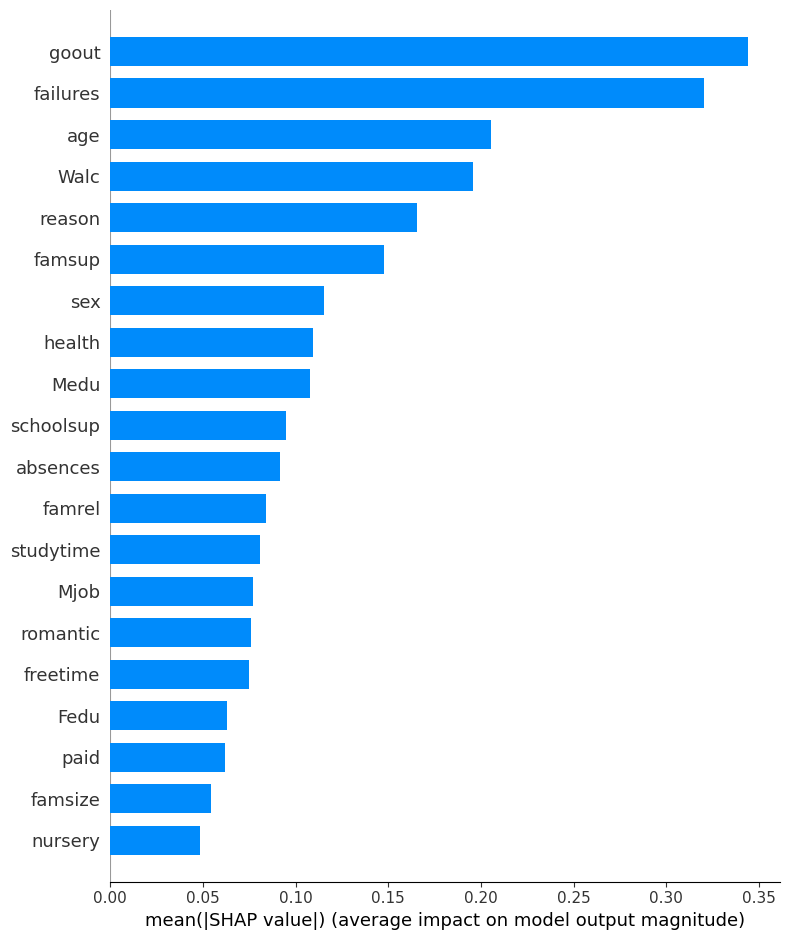


Training Decision Tree for binary classification...
Generating SHAP for Decision Tree (binary)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP failed for Decision Tree: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Training Random Forest for binary classification...
Generating SHAP for Random Forest (binary)...


<Figure size 640x480 with 0 Axes>

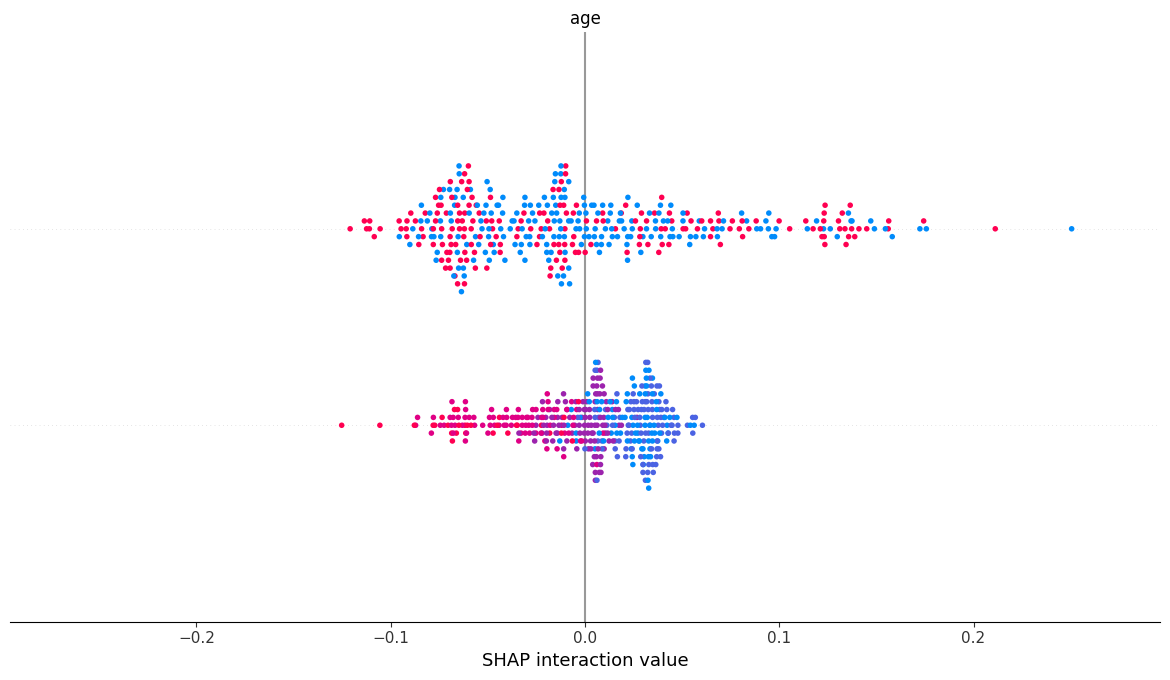


Training XGBoost for binary classification...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:33:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Generating SHAP for XGBoost (binary)...


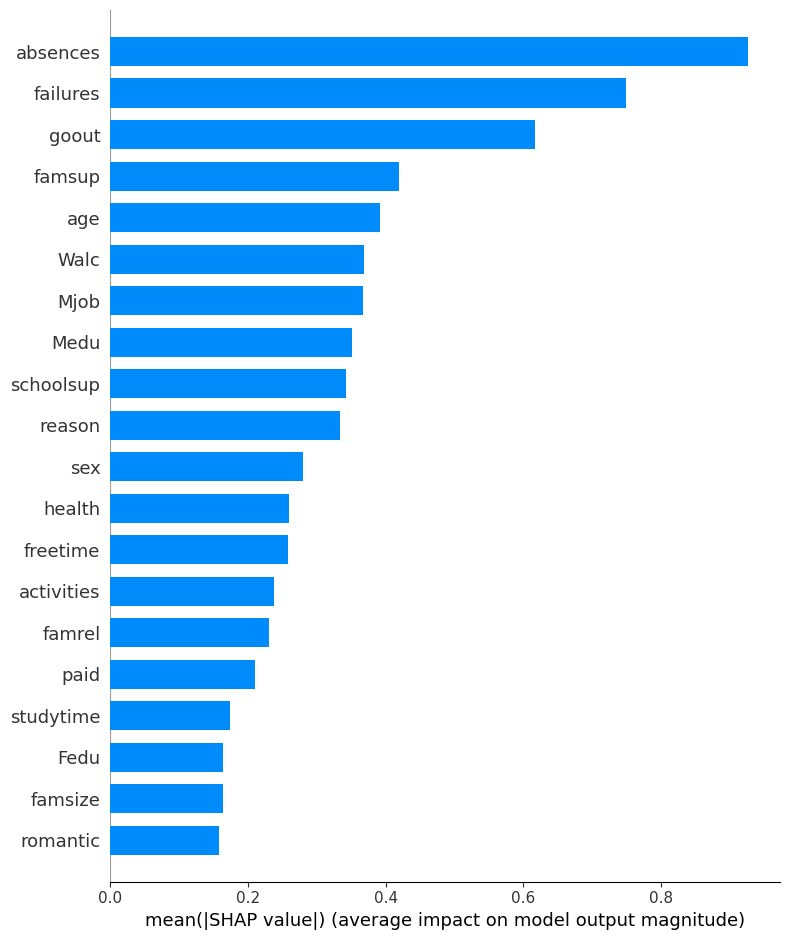


Training LightGBM for binary classification...
[LightGBM] [Info] Number of positive: 265, number of negative: 130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670886 -> initscore=0.712195
[LightGBM] [Info] Start training from score 0.712195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

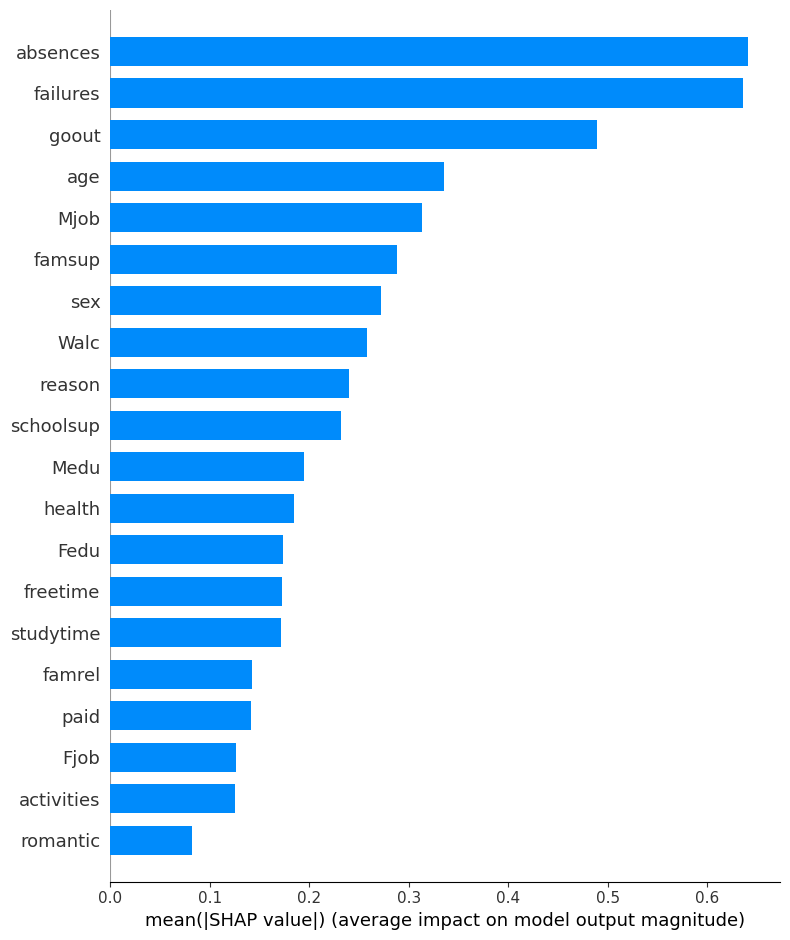


Training CatBoost for binary classification...
Generating SHAP for CatBoost (binary)...


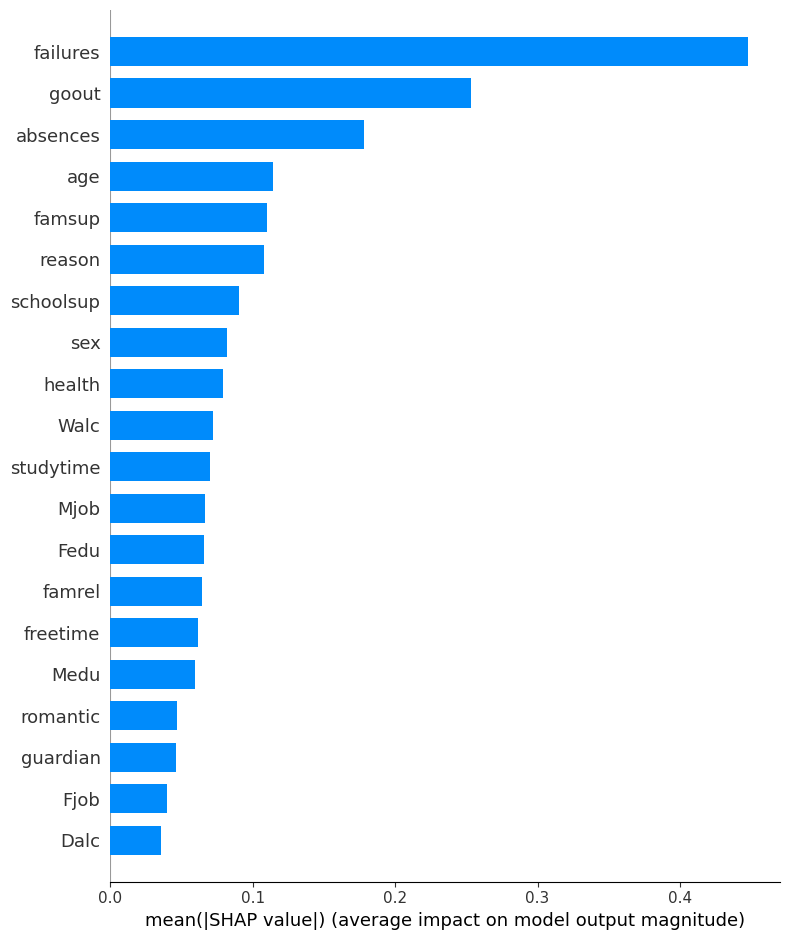


Training SVM for binary classification...
Generating SHAP for SVM (binary)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP failed for SVM: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Training Logistic Regression for 5class classification...
Generating SHAP for Logistic Regression (5class)...


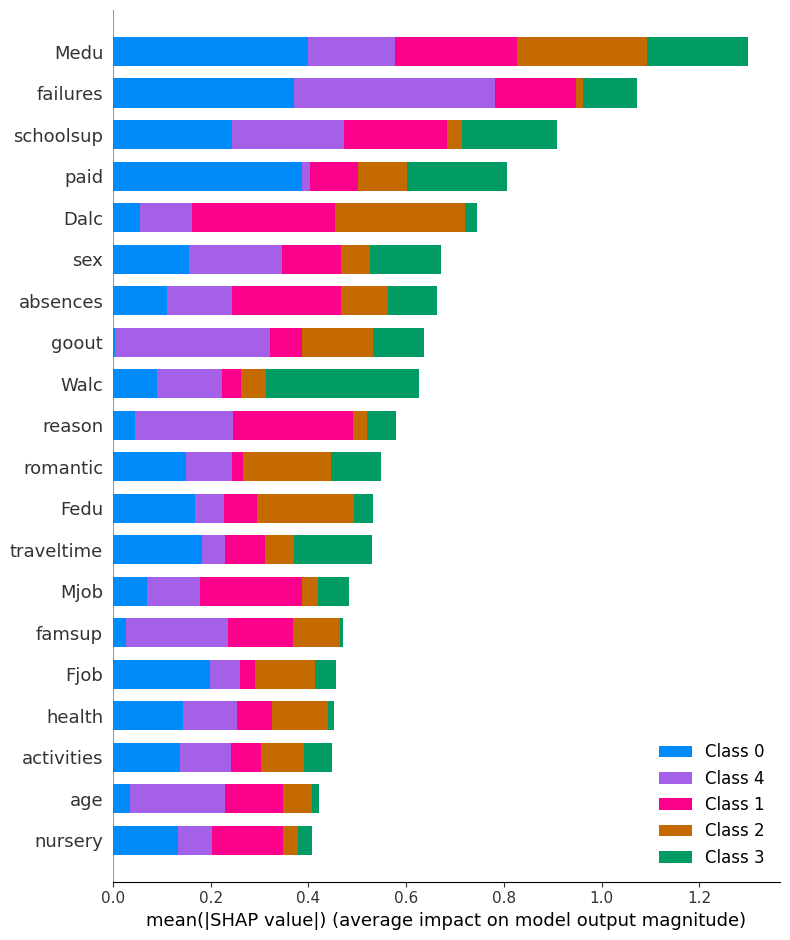


Training Decision Tree for 5class classification...
Generating SHAP for Decision Tree (5class)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP failed for Decision Tree: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Training Random Forest for 5class classification...
Generating SHAP for Random Forest (5class)...


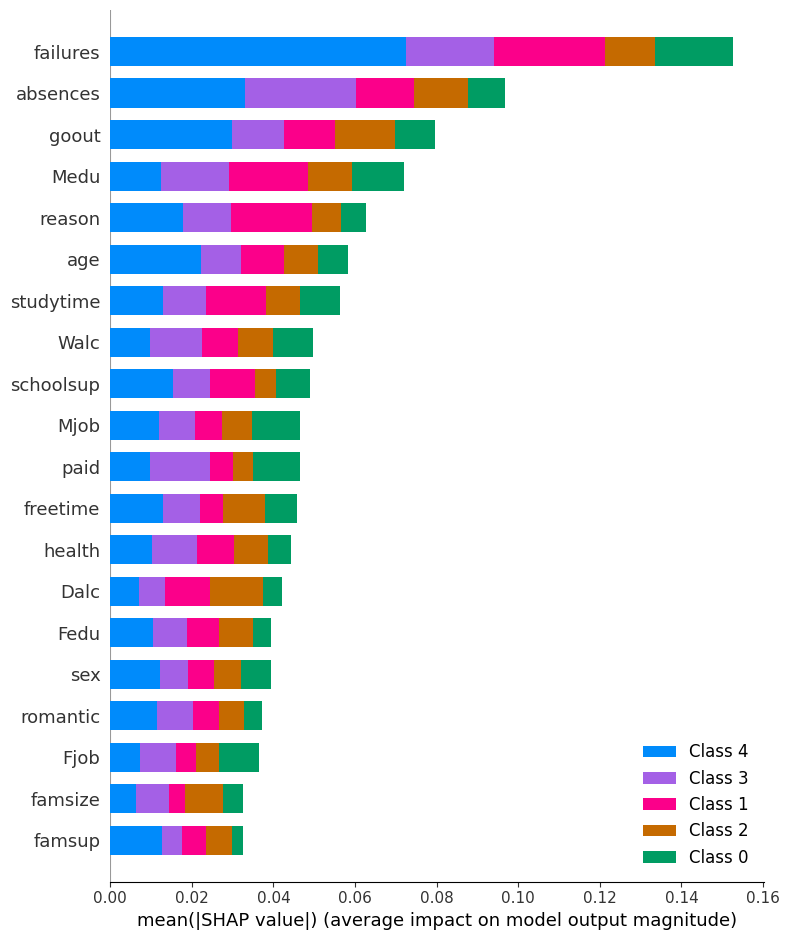


Training XGBoost for 5class classification...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:35:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Generating SHAP for XGBoost (5class)...


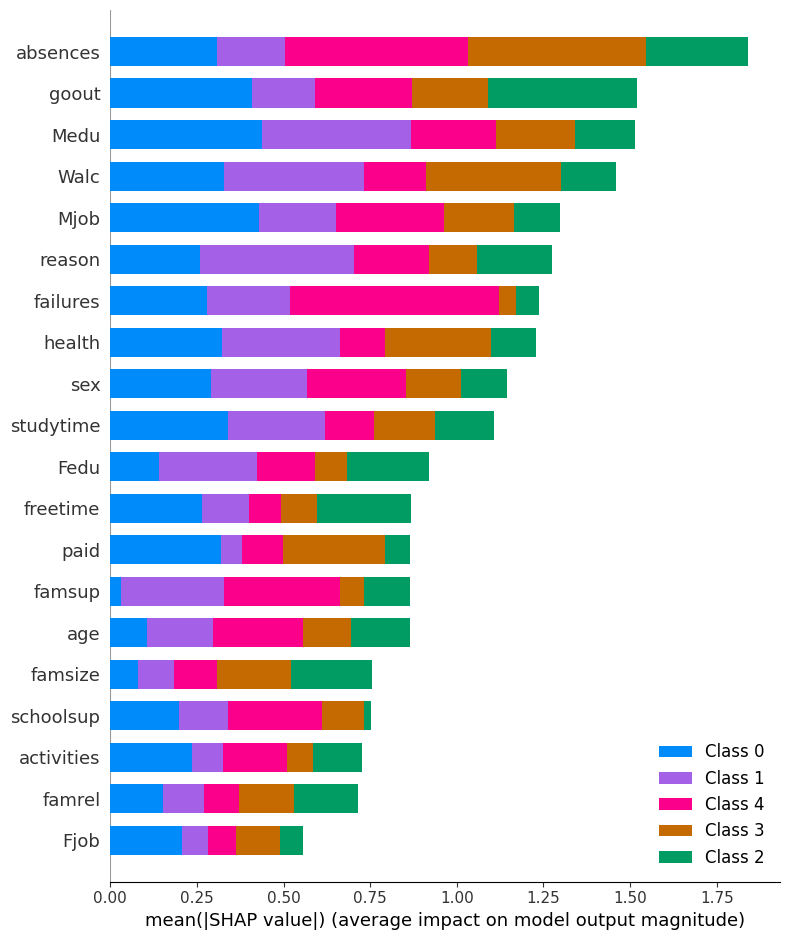


Training LightGBM for 5class classification...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 29
[LightGBM] [Info] Start training from score -2.290006
[LightGBM] [Info] Start training from score -1.884541
[LightGBM] [Info] Start training from score -1.851751
[LightGBM] [Info] Start training from score -1.344157
[LightGBM] [Info] Start training from score -1.111351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

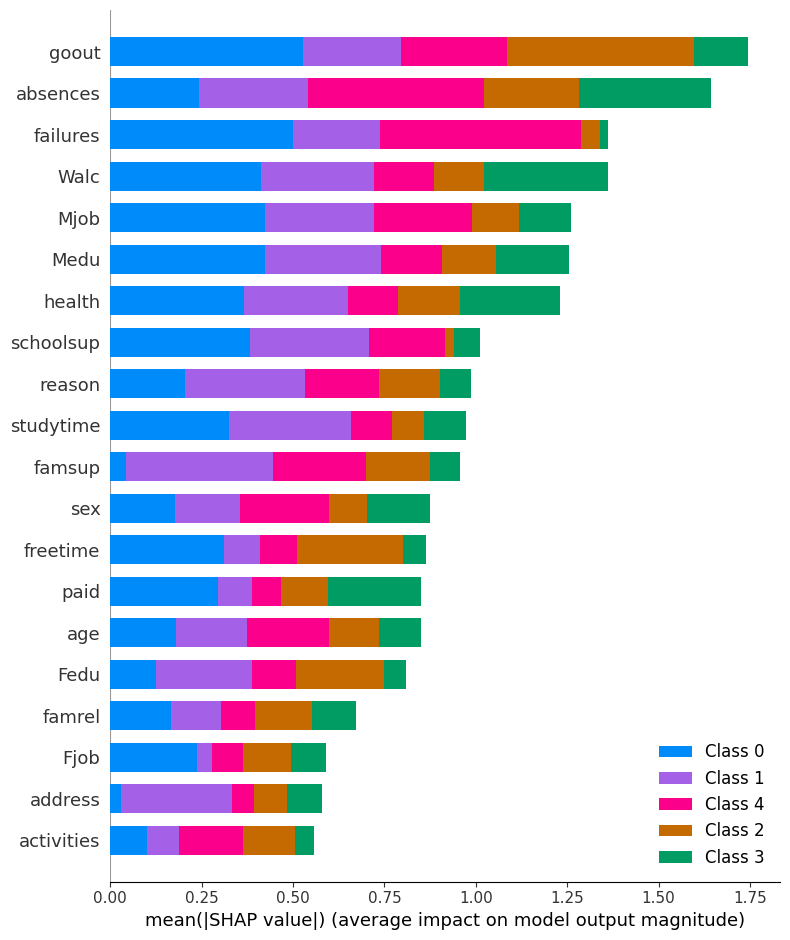


Training CatBoost for 5class classification...
Generating SHAP for CatBoost (5class)...


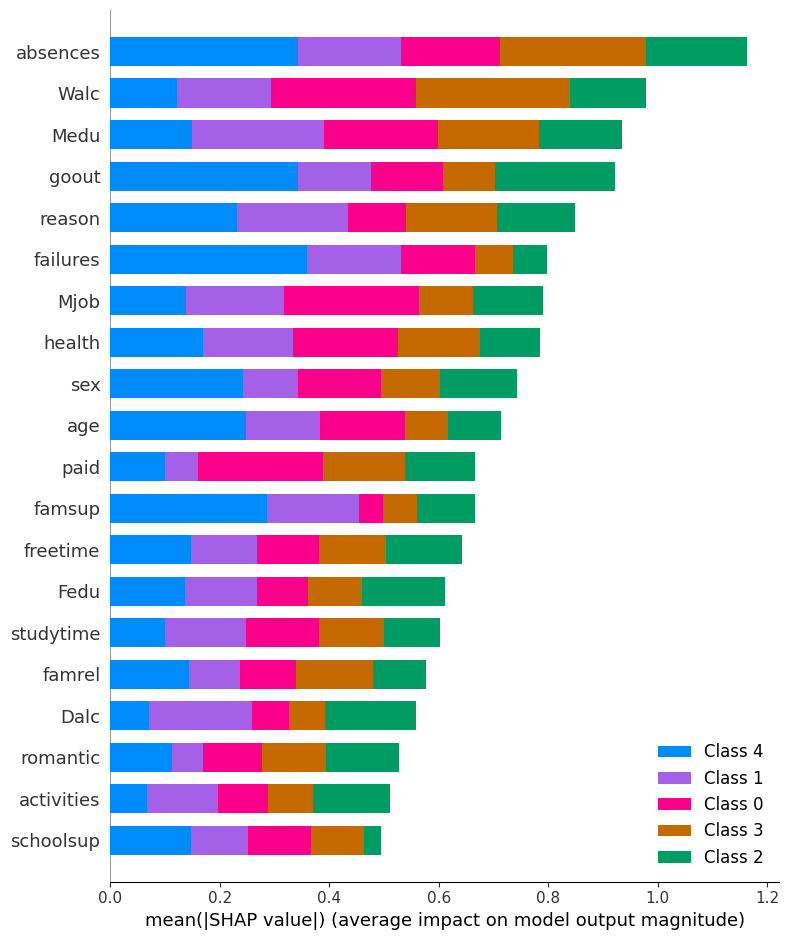


Training SVM for 5class classification...
Generating SHAP for SVM (5class)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP failed for SVM: The shape of the shap_values matrix does not match the shape of the provided data matrix.

=== Binary Classification Results ===
                 Model                              Best Params  Accuracy  \
0  Logistic Regression                               {'C': 0.1}  0.726582   
1        Decision Tree                         {'max_depth': 5}  0.817722   
2        Random Forest   {'max_depth': 10, 'n_estimators': 100}  0.994937   
3              XGBoost    {'max_depth': 5, 'n_estimators': 100}  1.000000   
4             LightGBM  {'n_estimators': 100, 'num_leaves': 31}  1.000000   
5             CatBoost          {'depth': 5, 'iterations': 100}  0.908861   
6                  SVM                {'C': 1, 'kernel': 'rbf'}  0.853165   

   Precision    Recall  F1 Score   ROC AUC  
0   0.697906  0.633599  0.640837  0.776807  
1   0.810417  0.762264  0.778048  0.834078  
2   0.996255  0.992308  0.994244  1.000000  
3   1.000000  1.000000  1.000000  1.000000  
4   1.00

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

shap.initjs()

# Load dataset
df = pd.read_csv("student-mat.csv", delimiter=";")
df = df.drop(columns=["school", "G1", "G2"])

# Target engineering
df["G3_binary"] = df["G3"].apply(lambda x: 1 if x >= 10 else 0)

def convert_grade(g3):
    if g3 >= 16:
        return 'A'
    elif g3 >= 14:
        return 'B'
    elif g3 >= 12:
        return 'C'
    elif g3 >= 10:
        return 'D'
    else:
        return 'F'

df["G3_5class"] = df["G3"].apply(convert_grade)
df = df.drop(columns=["G3"])

# Encode categorical variables
categorical_cols = df.select_dtypes(include="object").columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Features and targets
X = df.drop(columns=["G3_binary", "G3_5class"])
y_binary = df["G3_binary"]
y_5class = df["G3_5class"]

# Scale for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Models and parameters
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.1, 1]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [5, 10]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [100], 'max_depth': [10]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {'n_estimators': [100], 'max_depth': [5]}),
    "LightGBM": (LGBMClassifier(), {'n_estimators': [100], 'num_leaves': [31]}),
    "CatBoost": (CatBoostClassifier(verbose=0), {'iterations': [100], 'depth': [5]}),
    "SVM": (SVC(probability=True), {'C': [1], 'kernel': ['rbf']})
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation + SHAP
def evaluate_model(name, model, param_grid, X, y, task_type="binary"):
    print(f"\nTraining {name} for {task_type} classification...")
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    if name == "SVM":
        grid.fit(X_scaled, y)
        X_used = X_scaled
    else:
        grid.fit(X, y)
        X_used = X

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_used)

    result = {
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, average='macro'),
        "Recall": recall_score(y, y_pred, average='macro'),
        "F1 Score": f1_score(y, y_pred, average='macro'),
    }

    # ROC AUC only for binary
    if task_type == "binary":
        try:
            y_proba = best_model.predict_proba(X_used)[:, 1]
            result["ROC AUC"] = roc_auc_score(y, y_proba)
        except:
            result["ROC AUC"] = None

    # SHAP Explanation
    try:
        print(f"Generating SHAP for {name} ({task_type})...")
        if "XGBoost" in name or "LightGBM" in name or "Random Forest" in name or "CatBoost" in name:
            explainer = shap.Explainer(best_model)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X, plot_type="bar", show=True)
        elif name == "Logistic Regression":
            explainer = shap.LinearExplainer(best_model, X)
            shap_values = explainer.shap_values(X)
            shap.summary_plot(shap_values, X, plot_type="bar", show=True)
        else:
            background = shap.kmeans(X_used, 10)
            explainer = shap.KernelExplainer(best_model.predict_proba, background)
            shap_values = explainer.shap_values(X_used[:100])
            index = 1 if task_type == "binary" else 0
            shap.summary_plot(shap_values[index], X.iloc[:100], plot_type="bar", show=True)
    except Exception as e:
        print(f"SHAP failed for {name}: {e}")

    return result

# Run binary classification
results_binary = []
for name, (model, params) in models.items():
    res = evaluate_model(name, model, params, X, y_binary, task_type="binary")
    results_binary.append(res)

# Run 5-level classification
results_5class = []
for name, (model, params) in models.items():
    res = evaluate_model(name, model, params, X, y_5class, task_type="5class")
    results_5class.append(res)

# Show results
print("\n=== Binary Classification Results ===")
print(pd.DataFrame(results_binary))

print("\n=== 5-Level Classification Results ===")
print(pd.DataFrame(results_5class))


Training Logistic Regression for binary classification...
Generating SHAP for Logistic Regression (binary)...


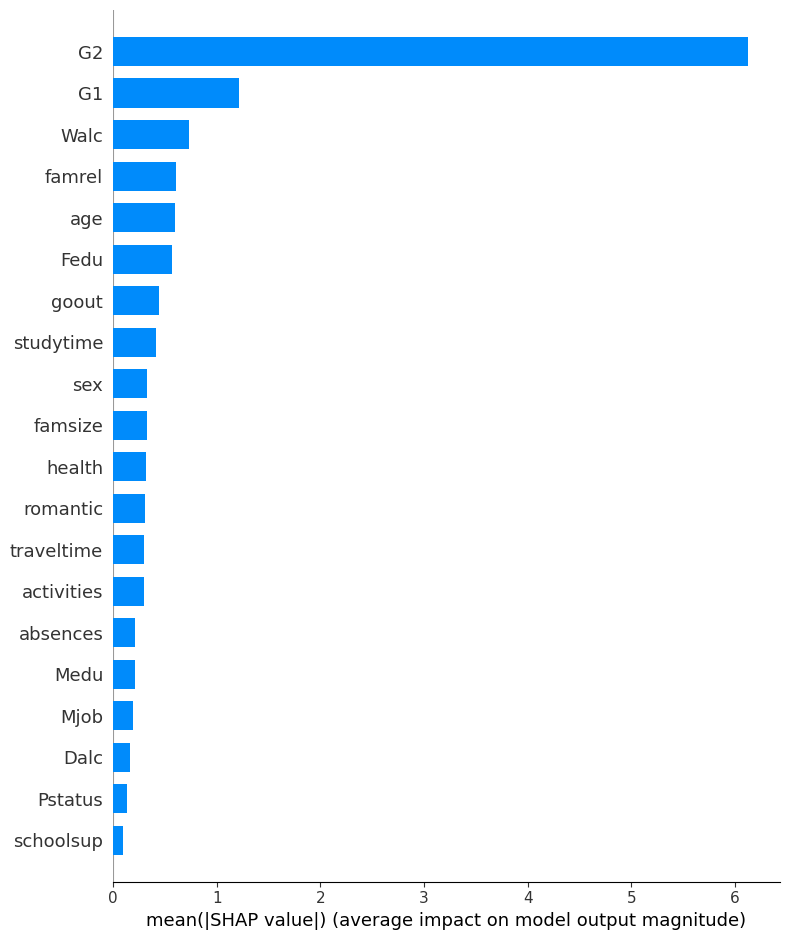


Training Decision Tree for binary classification...
Generating SHAP for Decision Tree (binary)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP failed for Decision Tree: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Training Random Forest for binary classification...
Generating SHAP for Random Forest (binary)...


<Figure size 640x480 with 0 Axes>

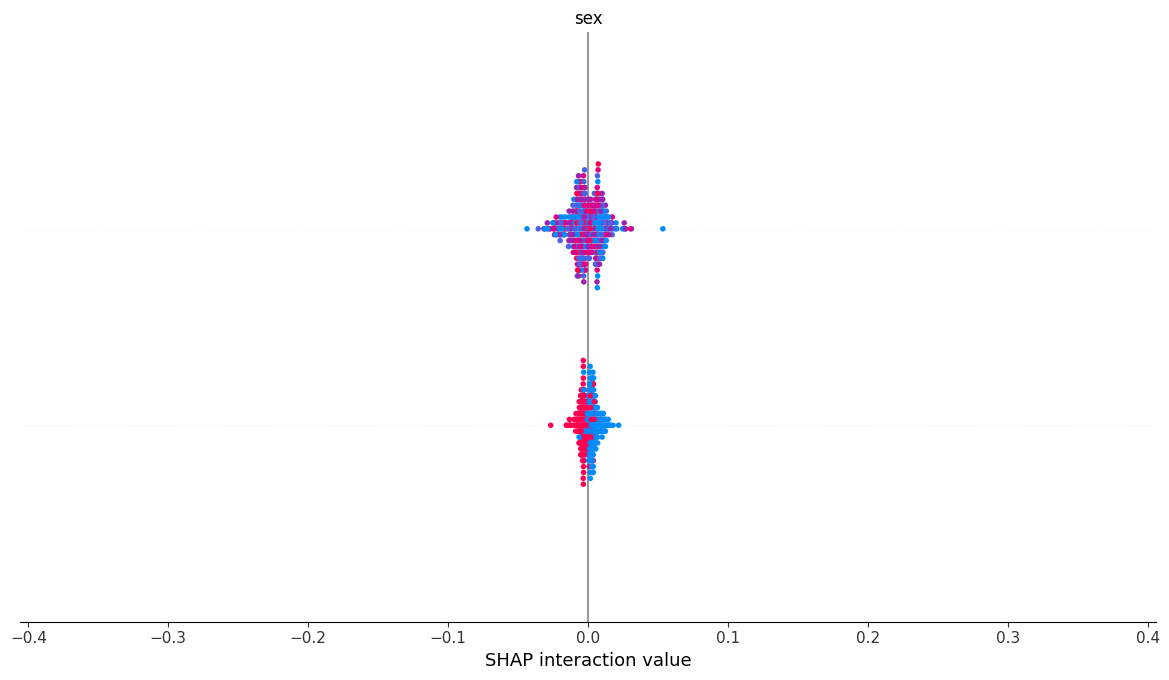


Training XGBoost for binary classification...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Generating SHAP for XGBoost (binary)...


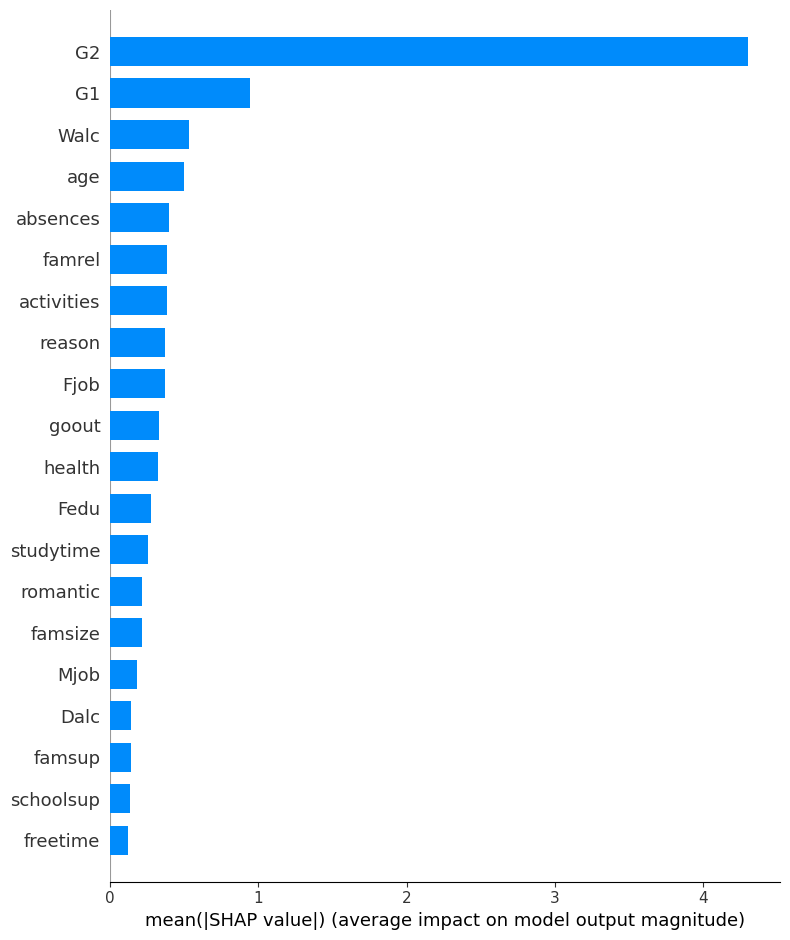


Training LightGBM for binary classification...
[LightGBM] [Info] Number of positive: 265, number of negative: 130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670886 -> initscore=0.712195
[LightGBM] [Info] Start training from score 0.712195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

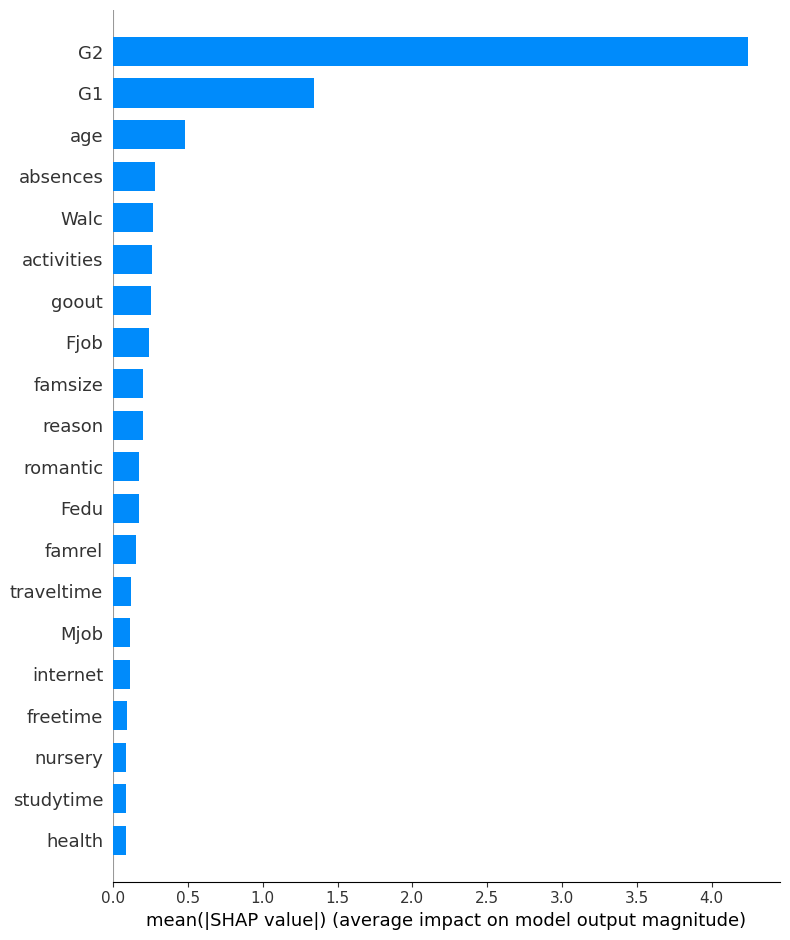


Training CatBoost for binary classification...
Generating SHAP for CatBoost (binary)...


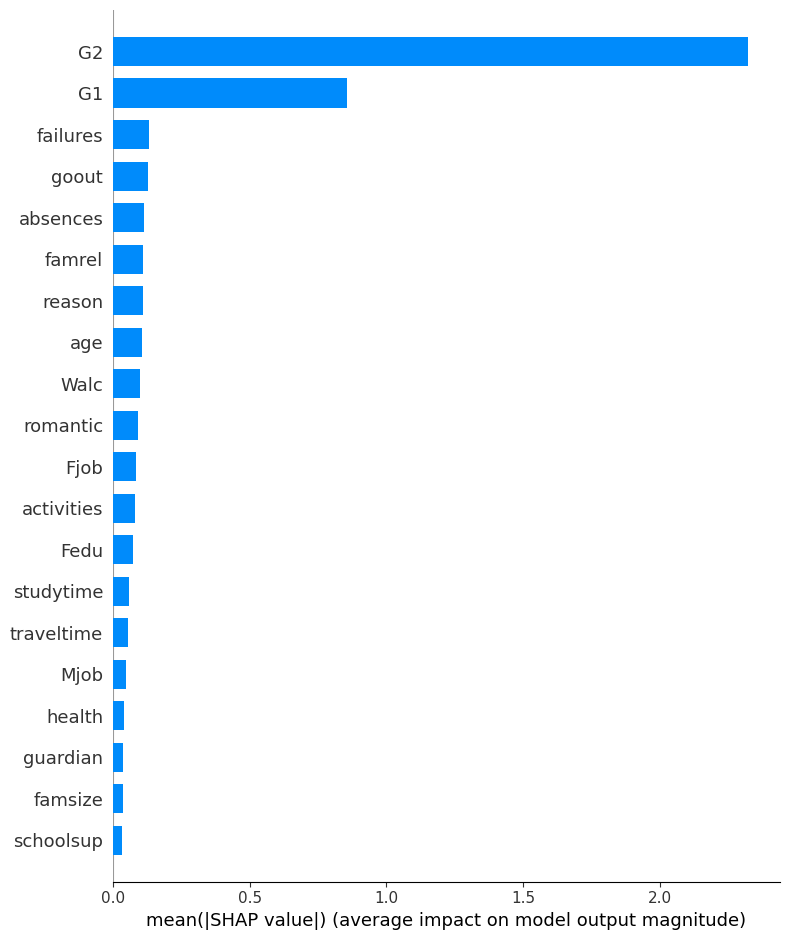


Training SVM for binary classification...
Generating SHAP for SVM (binary)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP failed for SVM: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Training Logistic Regression for 5class classification...
Generating SHAP for Logistic Regression (5class)...


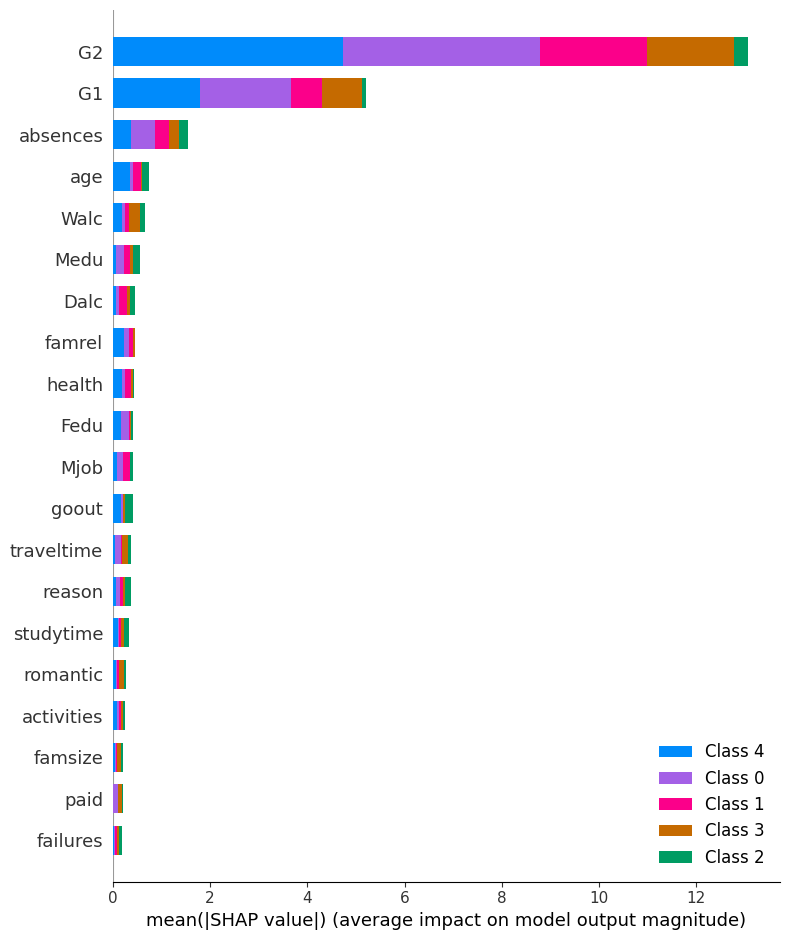


Training Decision Tree for 5class classification...
Generating SHAP for Decision Tree (5class)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP failed for Decision Tree: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Training Random Forest for 5class classification...
Generating SHAP for Random Forest (5class)...


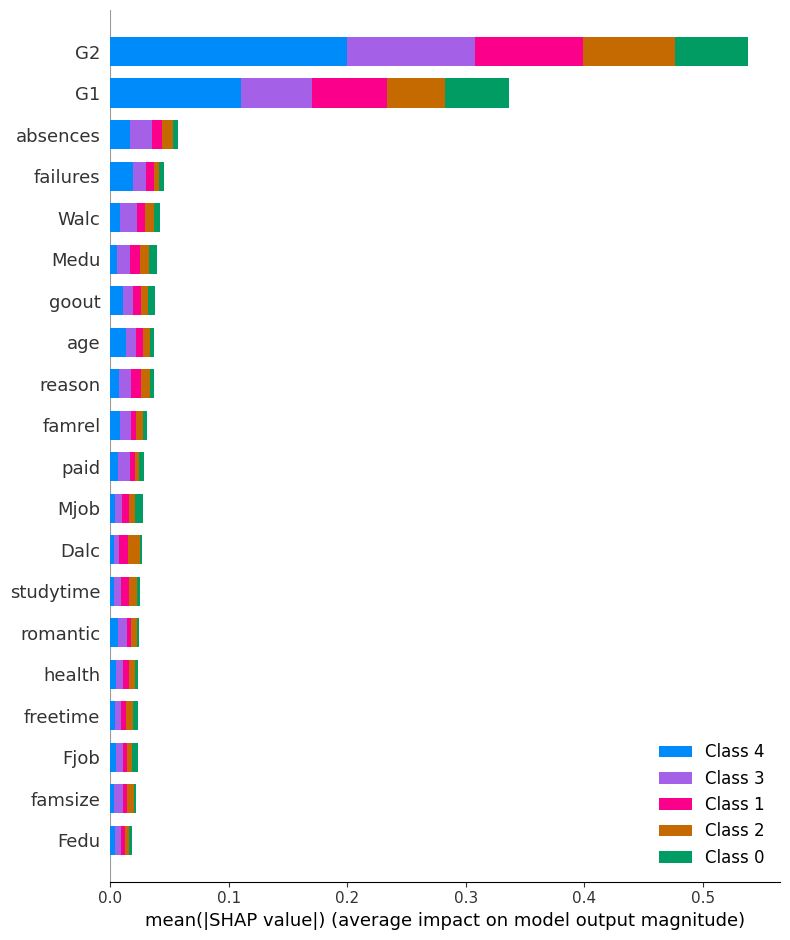


Training XGBoost for 5class classification...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Generating SHAP for XGBoost (5class)...


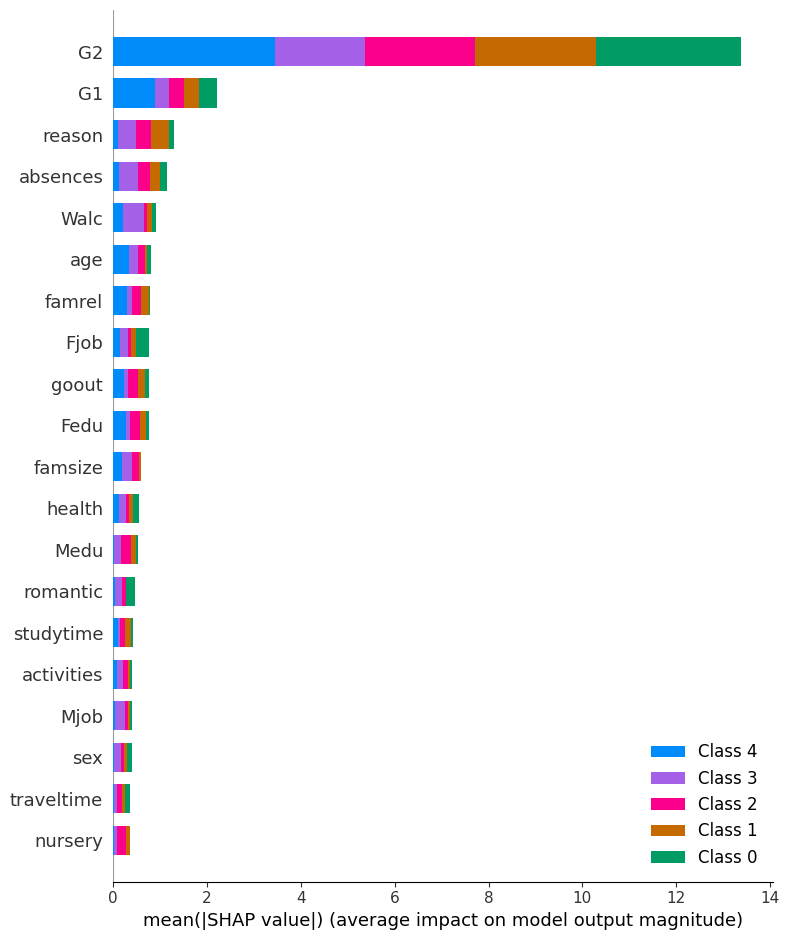


Training LightGBM for 5class classification...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 31
[LightGBM] [Info] Start training from score -2.290006
[LightGBM] [Info] Start training from score -1.884541
[LightGBM] [Info] Start training from score -1.851751
[LightGBM] [Info] Start training from score -1.344157
[LightGBM] [Info] Start training from score -1.111351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

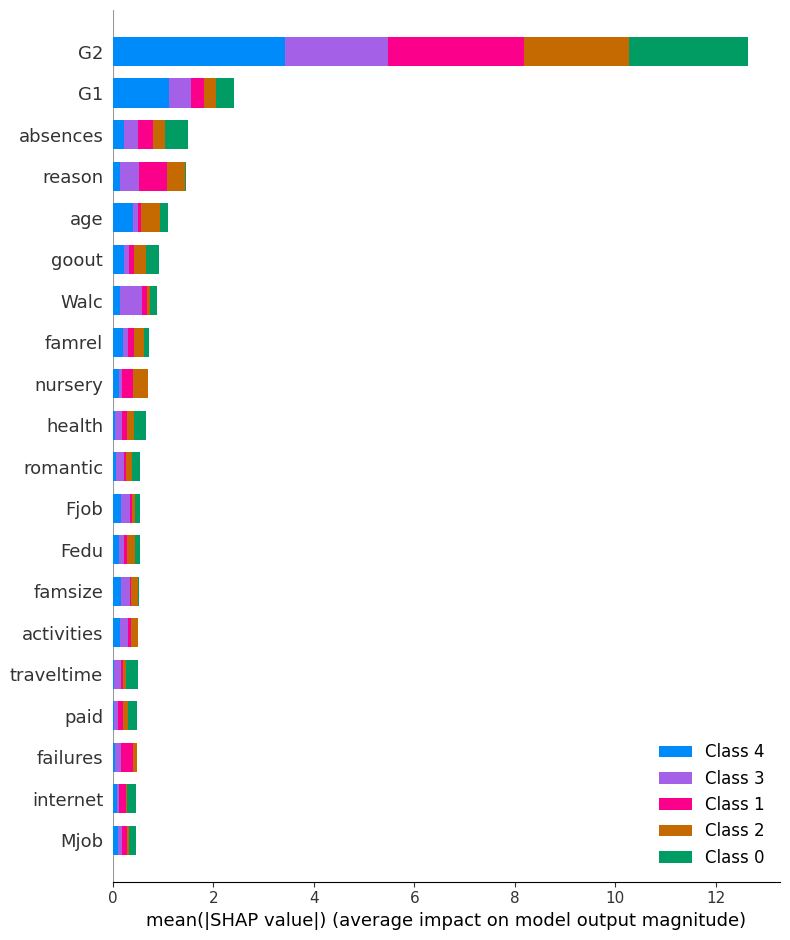


Training CatBoost for 5class classification...
Generating SHAP for CatBoost (5class)...


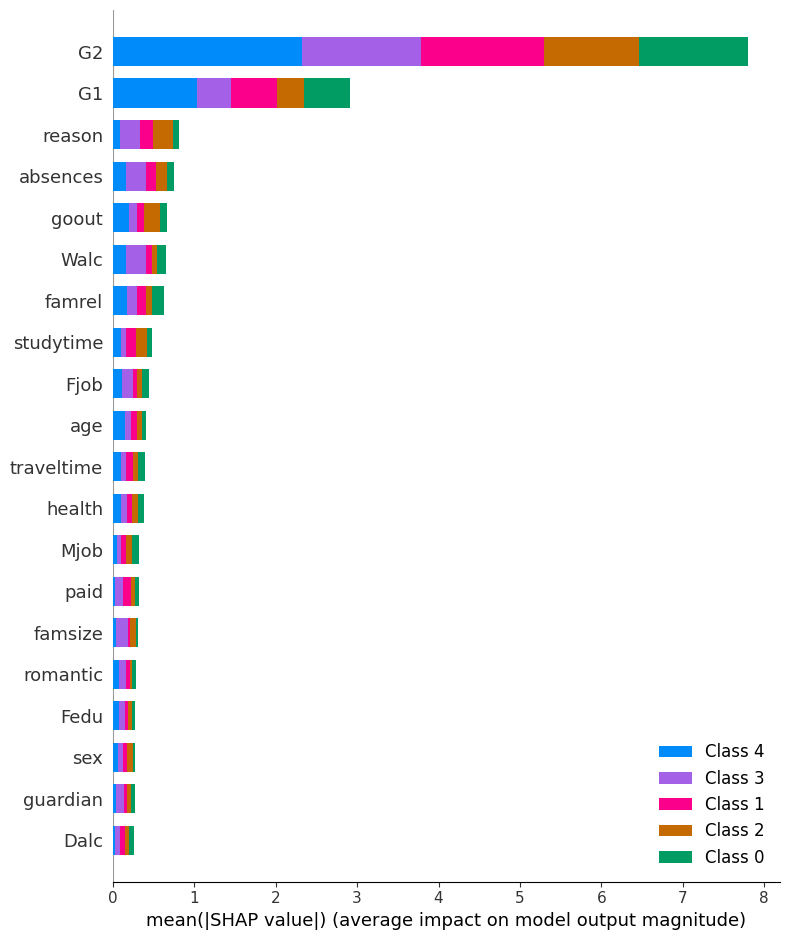


Training SVM for 5class classification...
Generating SHAP for SVM (5class)...


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP failed for SVM: The shape of the shap_values matrix does not match the shape of the provided data matrix.

=== Binary Classification Results ===
                 Model                              Best Params  Accuracy  \
0  Logistic Regression                                 {'C': 1}  0.951899   
1        Decision Tree                        {'max_depth': 10}  0.987342   
2        Random Forest   {'max_depth': 10, 'n_estimators': 100}  1.000000   
3              XGBoost    {'max_depth': 5, 'n_estimators': 100}  1.000000   
4             LightGBM  {'n_estimators': 100, 'num_leaves': 31}  1.000000   
5             CatBoost          {'depth': 5, 'iterations': 100}  0.997468   
6                  SVM                {'C': 1, 'kernel': 'rbf'}  0.979747   

   Precision    Recall  F1 Score   ROC AUC  
0   0.946319  0.944557  0.945430  0.991553  
1   0.988600  0.982729  0.985582  0.999274  
2   1.000000  1.000000  1.000000  1.000000  
3   1.000000  1.000000  1.000000  1.000000  
4   1.00

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

shap.initjs()

# Load dataset
df = pd.read_csv("student-mat.csv", delimiter=";")
df = df.drop(columns=["school"])

# Target engineering
df["G3_binary"] = df["G3"].apply(lambda x: 1 if x >= 10 else 0)

def convert_grade(g3):
    if g3 >= 16:
        return 'A'
    elif g3 >= 14:
        return 'B'
    elif g3 >= 12:
        return 'C'
    elif g3 >= 10:
        return 'D'
    else:
        return 'F'

df["G3_5class"] = df["G3"].apply(convert_grade)
df = df.drop(columns=["G3"])

# Encode categorical variables
categorical_cols = df.select_dtypes(include="object").columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Features and targets
X = df.drop(columns=["G3_binary", "G3_5class"])
y_binary = df["G3_binary"]
y_5class = df["G3_5class"]

# Scale for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Models and parameters
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.1, 1]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [5, 10]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [100], 'max_depth': [10]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {'n_estimators': [100], 'max_depth': [5]}),
    "LightGBM": (LGBMClassifier(), {'n_estimators': [100], 'num_leaves': [31]}),
    "CatBoost": (CatBoostClassifier(verbose=0), {'iterations': [100], 'depth': [5]}),
    "SVM": (SVC(probability=True), {'C': [1], 'kernel': ['rbf']})
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation + SHAP
def evaluate_model(name, model, param_grid, X, y, task_type="binary"):
    print(f"\nTraining {name} for {task_type} classification...")
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    if name == "SVM":
        grid.fit(X_scaled, y)
        X_used = X_scaled
    else:
        grid.fit(X, y)
        X_used = X

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_used)

    result = {
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, average='macro'),
        "Recall": recall_score(y, y_pred, average='macro'),
        "F1 Score": f1_score(y, y_pred, average='macro'),
    }

    # ROC AUC only for binary
    if task_type == "binary":
        try:
            y_proba = best_model.predict_proba(X_used)[:, 1]
            result["ROC AUC"] = roc_auc_score(y, y_proba)
        except:
            result["ROC AUC"] = None

    # SHAP Explanation
    try:
        print(f"Generating SHAP for {name} ({task_type})...")
        if "XGBoost" in name or "LightGBM" in name or "Random Forest" in name or "CatBoost" in name:
            explainer = shap.Explainer(best_model)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X, plot_type="bar", show=True)
        elif name == "Logistic Regression":
            explainer = shap.LinearExplainer(best_model, X)
            shap_values = explainer.shap_values(X)
            shap.summary_plot(shap_values, X, plot_type="bar", show=True)
        else:
            background = shap.kmeans(X_used, 10)
            explainer = shap.KernelExplainer(best_model.predict_proba, background)
            shap_values = explainer.shap_values(X_used[:100])
            index = 1 if task_type == "binary" else 0
            shap.summary_plot(shap_values[index], X.iloc[:100], plot_type="bar", show=True)
    except Exception as e:
        print(f"SHAP failed for {name}: {e}")

    return result

# Run binary classification
results_binary = []
for name, (model, params) in models.items():
    res = evaluate_model(name, model, params, X, y_binary, task_type="binary")
    results_binary.append(res)

# Run 5-level classification
results_5class = []
for name, (model, params) in models.items():
    res = evaluate_model(name, model, params, X, y_5class, task_type="5class")
    results_5class.append(res)

# Show results
print("\n=== Binary Classification Results ===")
print(pd.DataFrame(results_binary))

print("\n=== 5-Level Classification Results ===")
print(pd.DataFrame(results_5class))